# Train RAMS Deep Neural Network on Proba-V Dataset
![proba_v_dataset](media/RAMS.png "Logo Title Text 1")

The following notebook provides a script to train the residual attention network for multi-image super-resolution (RAMS). It makes use of the pre-processed dataset (train and validation) saved in the 'dataset' folder and using the main settings it selects a band to train with. 

**NB**: We strongly discouraged to run this notebook without an available GPU on the host machine. The original training (ckpt folder) has been performed on a 2080 Ti GPU card with 11GB of memory in approximately 24 hours.

**The notebook is divided in**:
- 1.0 [Dataset Loading](#loading)
- 2.0 [Dataset Pre-Processing](#preprocessing)
    - 2.1 Make patches
    - 2.2 Clarity patches check
    - 2.3 Pre-augment dataset (temporal permutation)
- 3.0 [Build the network](#network)
- 4.0 [Train the network](#train)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.network import RAMS
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile

2024-02-07 09:50:41.411326: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 09:50:42.012402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 09:50:42.012518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 09:50:42.145992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 09:50:42.412354: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 09:50:42.415514: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
# gpu settings (we strongly discouraged to run this notebook without an available GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset_mq_5' # pre-processed dataset path
name_net = 'RAMS_mq' # name of the network
LR_SIZE = 32 # pathces dimension
SCALE = 5 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'GREEN' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}_retrain' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'result_mq_5' # submission dir

In [4]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 25 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 100 # number of epochs

In [5]:
# create logs folder
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

<a id="loading"></a>
# 1.0 Dataset loading

In [6]:
# load training dataset
X_train = np.load(os.path.join(PATH_DATASET, f'X_{band}_train.npy'))
y_train = np.load(os.path.join(PATH_DATASET, f'y_{band}_train.npy'))
y_train_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_train_masks.npy'))

In [7]:
# load validation dataset
X_val = np.load(os.path.join(PATH_DATASET, f'X_{band}_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_{band}_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_val_masks.npy'))

In [8]:
# print loaded dataset info
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('y_train_mask: ', y_train_mask.shape)


print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

X_train:  (98, 128, 128, 25)
y_train:  (98, 640, 640, 1)
y_train_mask:  (98, 640, 640, 3, 1)
X_val:  (1, 128, 128, 25)
y_val:  (1, 640, 640, 1)
y_val_mask:  (1, 640, 640, 3, 1)


<a id="preprocessing"></a>
# 2.0 Dataset Pre-Processing

## 2.1 Make patches

In [9]:
# create patches for LR images
d = LR_SIZE  # 32x32 patches
s = OVERLAP  # overlapping patches
# Ex: n = (128-d)/s+1 = 7 -> 49 sub images from each image

X_train_patches = gen_sub(X_train,d,s)
X_val_patches = gen_sub(X_val,d,s)

Creating sub images:   0%|          | 0/98 [00:00<?, ?it/s]

(1568, 32, 32, 25)


Creating sub images:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 32, 32, 25)


In [10]:
# create patches for HR images and masks
d = HR_SIZE  # 96x96 patches
s = OVERLAP * SCALE  # overlapping patches
# Ex: n = (384-d)/s+1 = 7 -> 49 sub images from each image

y_train_patches = gen_sub(y_train,d,s)
y_train_mask_patches = gen_sub(y_train_mask[:,:,:,:,0],d,s)


y_val_patches = gen_sub(y_val,d,s)
y_val_mask_patches = gen_sub(y_val_mask[:,:,:,:,0],d,s)

Creating sub images:   0%|          | 0/98 [00:00<?, ?it/s]

(1568, 160, 160, 1)


Creating sub images:   0%|          | 0/98 [00:00<?, ?it/s]

(1568, 160, 160, 3)


Creating sub images:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 160, 160, 1)


Creating sub images:   0%|          | 0/1 [00:00<?, ?it/s]

(16, 160, 160, 3)


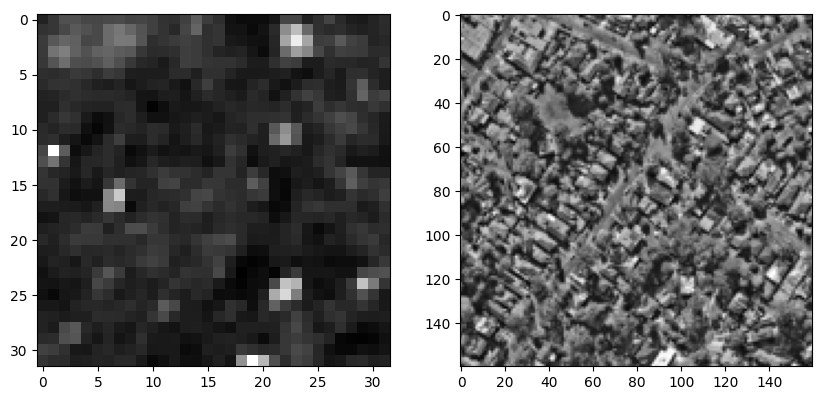

In [11]:
# print first patch and check if LR is in accordance with HR
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(X_train_patches[0,:,:,0], cmap = 'gray')
ax[1].imshow(y_train_patches[0,:,:,0], cmap = 'gray')

In [12]:
# free up memory
del X_train, y_train, y_train_mask

del X_val, y_val, y_val_mask

## 2.2 Clarity patches check

In [13]:
# find patches indices with a lower percentage of clean pixels in train array
patches_to_remove_train = [i for i,m in enumerate(y_train_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [14]:
# find patches indices with a lower percentage of clean pixels in validation array
patches_to_remove_val = [i for i,m in enumerate(y_val_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [15]:
# print number of patches to be removed
print(len(patches_to_remove_train))
print(len(patches_to_remove_val))

0
0


In [16]:
# remove patches not clean
X_train_patches = np.delete(X_train_patches,patches_to_remove_train,axis=0)
y_train_patches =  np.delete(y_train_patches,patches_to_remove_train,axis=0)
y_train_mask_patches =  np.delete(y_train_mask_patches,patches_to_remove_train,axis=0)

X_val_patches = np.delete(X_val_patches,patches_to_remove_val,axis=0)
y_val_patches =  np.delete(y_val_patches,patches_to_remove_val,axis=0)
y_val_mask_patches =  np.delete(y_val_mask_patches,patches_to_remove_val,axis=0)

<a id="network"></a>
# 3.0 Build the network

In [17]:
# build rams network
rams_network = RAMS(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)

In [18]:
# print architecture structure
rams_network.summary(line_length=120)

Model: "RAMS"
________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        
 input_1 (InputLayer)               [(None, None, None, 25)]            0           []                                  
                                                                                                                        
 lambda (Lambda)                    (None, None, None, 25)              0           ['input_1[0][0]']                   
                                                                                                                        
 lambda_1 (Lambda)                  (None, None, None, 25, 1)           0           ['lambda[0][0]']                    
                                                                                                                        
 lambda_2 (Lambda)

<a id="train"></a>
# 4.0 Train the network

In [19]:
trainer_rams = Trainer(rams_network, band, HR_SIZE, name_net,
                      loss=l1_loss,
                      metric=psnr,
                      optimizer=tf.keras.optimizers.Nadam(learning_rate=lr),
                      checkpoint_dir=os.path.join(checkpoint_dir),
                      log_dir=log_dir)

In [48]:
X_train_patches.shape

(1568, 32, 32, 25)

In [49]:
y_train_patches.shape

(1568, 160, 160, 1)

In [51]:
y_train_mask_patches.shape

(1568, 160, 160, 3)

In [ ]:
trainer_rams.fit(X_train_patches,
                [y_train_patches.astype('float32'), y_train_mask_patches], initial_epoch = 0,
                batch_size=BATCH_SIZE, evaluate_every=400, data_aug = True, epochs=EPOCHS_N,
                validation_data=(X_val_patches, [y_val_patches.astype('float32'), y_val_mask_patches])) 

2024-02-07 09:58:05.902197: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 963379200 exceeds 10% of free system memory.



Epoch 1/100


2024-02-07 09:58:07.203359: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 963379200 exceeds 10% of free system memory.
